<a href="https://colab.research.google.com/github/Mariyaben/Mitigating-Marine-Pollution-NCMPE/blob/main/Mitigating_Marine_Pollution_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/MyDrive")

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
import torch
from torchvision import datasets, transforms
import torchvision

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
dataset = datasets.ImageFolder('/content/MyDrive/MyDrive/Marine-Dataset/SOUVIK/train', transform = transform_train)

In [ ]:
dataset.classes

In [ ]:
def class_count(dataset):
    class_names = ['immature', 'mature']
    class_counts = {class_name: 0 for class_name in class_names}

    for _, label in dataset:
        class_counts[class_names[label]] += 1

    for class_name, count in class_counts.items():
        print(f"Class {class_name}: {count} images")

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
classes = ['no-plastic', 'plastic']

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [ ]:
print(labels)
print(labels.shape)
print(labels.dtype)

tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
torch.Size([16])
torch.int64


In [ ]:
def unnormalize_img(np_image):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    npimg = np.transpose(np_image, (1, 2, 0))
    npimg = (npimg * std) + mean

    return npimg

In [ ]:
def imshow(img, title=None):
    npimg = img.numpy()

    npimg = unnormalize_img(npimg)

    plt.imshow(npimg)

    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
def display_images_in_grid(image_list, labels,grid_size=(3, 3)):
    num_images = len(image_list)
    num_rows, num_cols = grid_size

    if num_images < num_rows * num_cols:
        print(f"Warning: Not enough images to fill the {num_rows}x{num_cols} grid.")
        return

    f, axarr = plt.subplots(num_rows, num_cols, figsize=(7, 7))

    for i in range(num_rows):
        for j in range(num_cols):
            img_idx = i * num_cols + j
            axarr[i, j].imshow(unnormalize_img(image_list[img_idx].numpy()))
            axarr[i, j].axis("off")

            axarr[i, j].set_title(f"{classes[labels[img_idx]].capitalize()}")

    plt.tight_layout()
    plt.show()

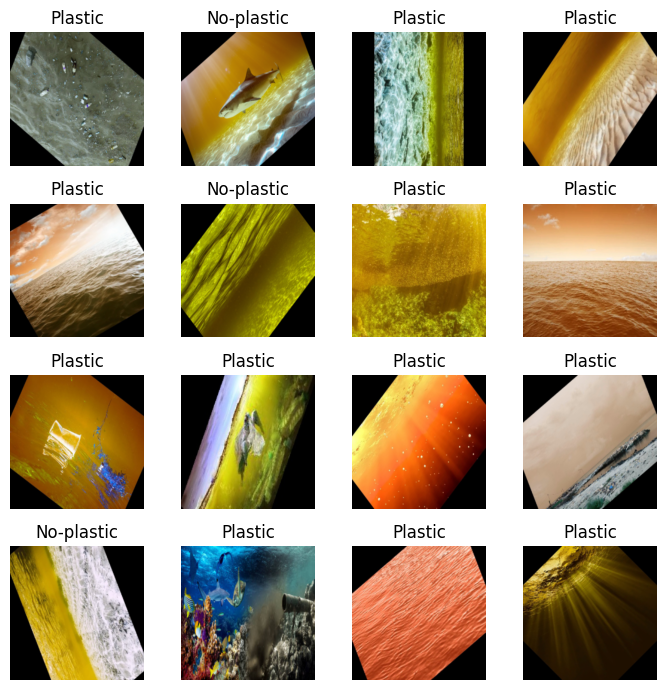

In [ ]:
display_images_in_grid(images, labels, (4,4))

## ResNet 50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for params in model.parameters():
    params.requires_grad_ = False

In [ ]:
last_layer_in_features = model.fc.in_features

In [ ]:
model.fc = nn.Sequential(
            nn.Linear(last_layer_in_features, 1),
            nn.Sigmoid()
)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
learning_rate = 0.01

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

In [ ]:
import copy

def train_model(model, train_data, optimizer, criterion, epochs=12, val_data=None, early_stopping=False, early_stopping_patience=5):
    """
        Reusable function to train a pytorch model.

        Input:
            model: PyTorch Model
            train_data: DataSet Loader with Train Data
            epochs: (default = 12) Number of epochs the model should be trained
            val_data: (Optional) DataSet Loader with Validation Data to perform the model on unseen data
            early_stopping: (default = False) Whether the training should stop early to avoid overfitting
            early_stopping_patience: (default = 5) Patience value for early stopping

        Returns:
            model: PyTorch model trained on the given data
            history: History of the values containing, Train loss, Train Accuracy, Val Loss and Val Accuracy (If validation data provided)

    """

    if val_data is None and early_stopping is True:
        raise ValueError("Early stopping is done based on the models performance on validation data, so inorder to perform early stopping, pass in validation data or set early_stopping = False")


    train_loader = train_data
    val_loader = val_data

    best_loss = float('inf')
    best_model_weights = None
    best_model_weights = copy.deepcopy(model.state_dict())
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_accuracy'] = []
    history['val_accuracy'] = []

    for epoch in range(epochs):

        model.train() # model in train mode

        train_losses = []
        train_correct = 0
        train_total = 0

        for batch_num, input_data in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = input_data
            x = x.to(device).float()

            y = y.unsqueeze(1).float()
            y = y.to(device)

            output = model(x)

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            predicted = (output >= 0.5).float()

            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

            if batch_num % 500 == 0:
                print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch+1, batch_num, loss.item()))


        train_avg_loss = sum(train_losses) / len(train_losses)
        train_accuracy = 100 * train_correct / train_total
        print('Epoch %d | Training Loss %6.2f | Training Accuracy: %2.2f %%' % (epoch+1, train_avg_loss, train_accuracy))
        history['train_loss'].append(train_avg_loss)
        history['train_accuracy'].append(train_accuracy)

        if val_loader is not None:
            # Validation phase
            model.eval()

            val_losses = []
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch_num, val_data in enumerate(val_loader):
                    x, y = val_data
                    x = x.to(device).float()

                    y = y.unsqueeze(1).float()

                    y = y.to(device)

                    val_output = model(x)
                    val_loss = criterion(val_output, y)
                    val_losses.append(val_loss.item())

                    val_predicted = (val_output >= 0.5).float()

                    val_total += y.size(0)
                    val_correct += (val_predicted == y).sum().item()

            val_avg_loss = sum(val_losses) / len(val_losses)
            val_accuracy = 100 * val_correct / val_total
            print('Epoch %d | Validation Loss %6.2f | Validation Accuracy: %2.2f %%' % (epoch+1, val_avg_loss, val_accuracy))
            history['val_loss'].append(val_avg_loss)
            history['val_accuracy'].append(val_accuracy)

        if early_stopping is not False:
            # Early stopping
            if val_avg_loss < best_loss:
                best_loss = val_avg_loss
                best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
                patience = early_stopping_patience  # Reset patience counter
                print(f"Saving the best model at {epoch+1}th epoch.")
            else:
                patience -= 1
                if patience == 0:
                    print(f"Stopping the training")
                    break

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    return model, history

In [ ]:
num_epochs = 5
model, history = train_model(model, train_loader, optimizer, criterion, num_epochs, test_loader,  True, 3)

	Epoch 1 | Batch 0 | Loss   0.68


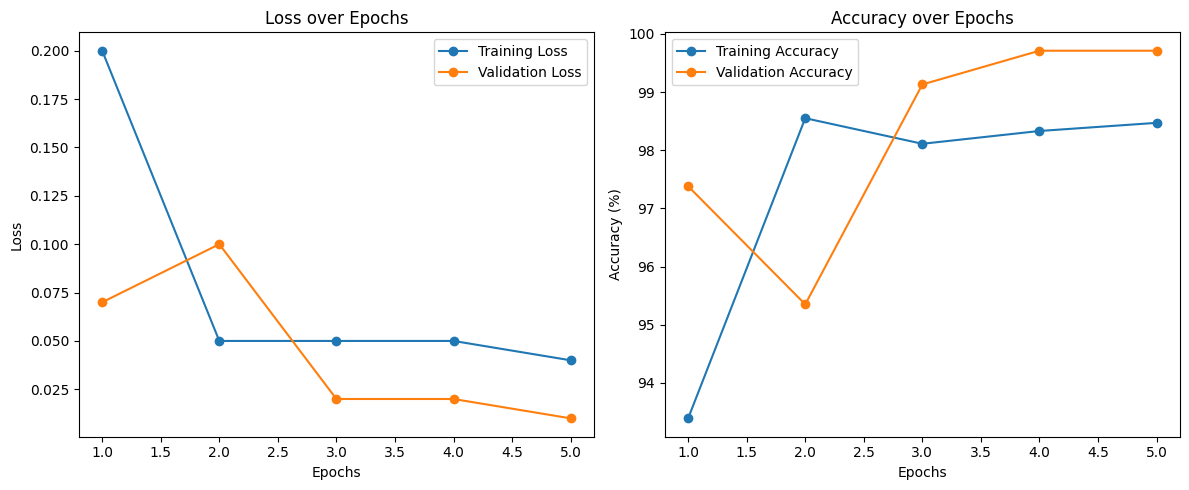

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = [1, 2, 3, 4, 5]
train_loss = [0.20, 0.05, 0.05, 0.05, 0.04]
val_loss = [0.07, 0.10, 0.02, 0.02, 0.01]
train_acc = [93.39, 98.55, 98.11, 98.33, 98.47]
val_acc = [97.38, 95.35, 99.13, 99.71, 99.71]

# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()